# import packages and read data

In [1]:
import scipy.io as scio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = scio.loadmat('spamData.mat')
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Aug 16 16:33:53 2021', '__version__': '1.0', '__globals__': [], 'Xtrain': array([[  0.   ,   0.   ,   0.   , ...,   4.5  ,  34.   , 108.   ],
       [  0.   ,   0.   ,   0.71 , ...,   1.974,  34.   , 229.   ],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   1.   ,   5.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   1.884,   9.   ,  98.   ],
       [  0.   ,   0.   ,   0.7  , ...,   1.333,   4.   ,  16.   ],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   1.   ,   4.   ]]), 'Xtest': array([[1.500e-01, 0.000e+00, 6.300e-01, ..., 1.111e+00, 7.000e+00,
        3.890e+02],
       [0.000e+00, 0.000e+00, 7.000e-01, ..., 1.820e+00, 1.800e+01,
        3.040e+02],
       [5.800e-01, 0.000e+00, 1.900e-01, ..., 3.015e+00, 2.100e+01,
        1.900e+02],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.142e+00, 3.000e+00,
        4.000e+01],
       [0.000e+00, 0.000e+00, 3.100e-01, ..., 1.515e+00, 1

In [3]:
X_train = pd.DataFrame(data['Xtrain'])
X_test = pd.DataFrame(data['Xtest'])
y_train = pd.DataFrame(data['ytrain'])
y_test = pd.DataFrame(data['ytest'])

In [4]:
# test the shape of data
print(X_train.shape)
print(X_test.shape)

(3065, 57)
(1536, 57)


# data Processing,use binarization:
###### binarize features: I(Xij > 0). In other words, if a feature is greater than 0,it’s simply set to 1. If it’s less than or equal to 0, it’s set to 0

In [5]:
X_train_b = X_train.applymap(lambda x:1 if x>0 else 0)
X_test_b = X_test.applymap(lambda x:1 if x>0 else 0)

## We assume y=1 is positive, y=0 is negative：

1.We need to compute value of λML. λML = y_train(y=1)/(y_train(y=1) + y_train(x=1))

2.According to yi，we need to find the data where y=yi in y_train , the probability of xj=1

3.Give a X which need to predict， compute the probability of y=1 and y=0


In [6]:
class Beta_Binomial_NaiveBayes_Classifier():

    '''      
        a(int) : firstparameter of Beta
        b(int) : second parameter of Beta
        X_train(pd.DataFrame) : features of train data
        y_train(pd.DataFrame) : label of train data
        X_test(pd.DataFrame) : features of test data
        y_test(pd.DataFrame) : label of test data
    '''
    def __init__(self, a, b, X_train, y_train, X_test, y_test):      
        self.a = a
        self.b = b
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    #calculate the piror probability of y = 1
    def calculate_lamdaML(self):
        return y_train.sum()[0] / y_train.size
    
    '''      
        pos(int) : positive number of give data
        neg(int) : nagative number of give data
    '''
    #calculate the Beta Posterior Predictive Distribution of positive label
    def calculate_Beta_PosteriorPredictiveDistribution(self, pos, neg):
        return (pos+self.a)/(pos+neg+self.a+self.b)
    
    #calculate a 57*4 matrix
    #the index i,j means the Beta probability where i-th feature of X equals 'j/2' and label is y='j mod 2'
    def calculate_PosteriorPredictiveDistribution(self):
        result = np.zeros((57,4))
        for i in range(0, X_train.shape[1]):
            Xi = self.X_train.iloc[:, i]
            num00 = Xi.loc[(Xi==0) & (y_train[0]==0) ].count()
            num01 = Xi.loc[(Xi==0) & (y_train[0]==1) ].count()
            num10 = Xi.loc[(Xi==1) & (y_train[0]==0) ].count()
            num11 = Xi.loc[(Xi==1) & (y_train[0]==1) ].count()
            result[i][2] = self.calculate_Beta_PosteriorPredictiveDistribution(num10, num00)
            result[i][0] = 1 - result[i][2]
            result[i][3] = self.calculate_Beta_PosteriorPredictiveDistribution(num11, num01)
            result[i][1] = 1 - result[i][3]
        return result
    
    '''      
        X_to_predict(pd.DataFrame) : Data to predict
    '''
    #input features ,predict the lable.
    def predict_label(self ,X_to_predict):
        
        predict = []
        posterior = np.log(self.calculate_PosteriorPredictiveDistribution())
        piror_1 = np.log(self.calculate_lamdaML())
        piror_0 = np.log(1 - self.calculate_lamdaML())
        
        # loop through each row
        for row_idx in range(0, X_to_predict.shape[0]):
            row = X_to_predict.loc[row_idx,:]
            p1 = piror_1
            p0 = piror_0
            # loop through each feature
            for col_idx in range(0, X_to_predict.shape[1]):
                x_val = row[col_idx]
                p1 += posterior[col_idx][x_val*2+1]
                p0 += posterior[col_idx][x_val*2]
            if p1 > p0:
                predict.append(1)
            else:
                predict.append(0)
            
        return predict
    
    '''      
        pred(list) : Predict label of data
        true(np.ndarray) : True label of data
    '''
    #calculate the error rate(%) of the predict label and true label
    def calculate_error(self, pred, true):
        return (pred^true).sum() / len(pred) * 100
    
    #return the train error rate and test error rate
    def run(self):
        train_predict = self.predict_label(self.X_train)
        test_predict = self.predict_label(self.X_test)
        # score and return results
        return self.calculate_error(train_predict, self.y_train[0].values), \
               self.calculate_error(test_predict, self.y_test[0].values)

## Q1(a)
## Plots of training and test error rates versus α,α = {0, 0.5, 1, 1.5, 2, · · · , 100}

D:\ana\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


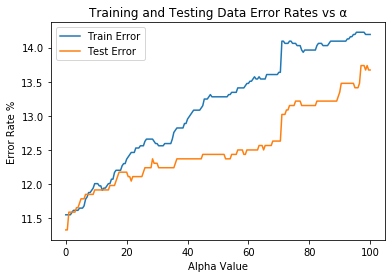

In [7]:
# initialise empty list for storage
alphas = list(np.arange(0, 100.5, 0.5))
train_error_list = []
test_error_list = []

# loop over alpha values
for alpha in alphas:
    bbn = Beta_Binomial_NaiveBayes_Classifier(alpha, alpha, X_train_b, y_train, X_test_b, y_test)
    train_error, test_error = bbn.run()
    train_error_list.append(train_error)
    test_error_list.append(test_error)

# plot chart
plt.plot(alphas, train_error_list, label='Train Error')
plt.plot(alphas, test_error_list, label='Test Error')
plt.ylabel('Error Rate %')
plt.xlabel('Alpha Value')
plt.title('Training and Testing Data Error Rates vs α')
plt.legend()
plt.show()

## Q1(b)
## What do you observe about the training and test errors as α change?
In summary, the errors for both train and test increase as α increases. <br>
For most of α, the test error rates are always higher than the train error rates. The best α for train data is 0, and the train error rate is about 11.2%. The best α for test data is about 0, and the train error rate is about 11.5%. And when α=70, the errors for both train and test increase the most fastly. 

## Q1(c)
## Training and testing error rates for α = 1, 10 and 100.

In [11]:
for alpha in [1, 10, 100]:
    index = alphas.index(alpha)
    print('When α = %d :train error rate is %f%% , test error rate is %f%%' %(alpha, train_error_list[index], test_error_list[index]))

When α = 1 :train error rate is 11.549755% , test error rate is 11.588542%
When α = 10 :train error rate is 12.006525% , test error rate is 11.914062%
When α = 100 :train error rate is 14.192496% , test error rate is 13.671875%
